# Project Outline
- Problem Statement
- Load Data and Preprocessing
    - Understand the metadata
- Exploratory Data Analysis
- Feature Selection and Engineering
- Split Data and Build Model
- Make Predictions and Evaluate Model
- Conclusion

# Problem Statement

Goal of this project: Forecast demand for bikes given different weather, temperature conditions, seasonality and other temporal conditions.

# Load Data and Preprocessing

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
bike_df = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv')

In [3]:
bike_df.shape

(17414, 10)

In [4]:
bike_df.tail()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0
17413,2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0


In [5]:
bike_df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [6]:
bike_df.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

## Understand the metadata

The columns in the dataset aren't very descriptive and so below is a breakdown for the metadata:
1. "timestamp" - timestamp field for grouping the data
2. "cnt" - the count of a new bike shares
3. "t1" - real temperature in C
4. "t2" - temperature in C "feels like"
5. "hum" - humidity in percentage
6. "wind_speed" - wind speed in km/h
7. "weather_code" - category of the weather : 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog
8. "is_holiday" - boolean field - 1 holiday / 0 non holiday
9. "is_weekend" - boolean field - 1 if the day is weekend
10. "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.


In [7]:
# check for missing values
bike_df.isnull().any()

timestamp       False
cnt             False
t1              False
t2              False
hum             False
wind_speed      False
weather_code    False
is_holiday      False
is_weekend      False
season          False
dtype: bool

Good news! Since there are no missing values we have less preprocessing to do.

# Exploratory Data Analysis

In [8]:
# rename columns
bike_df.rename(columns={'cnt': 'bike_count',
                        't1': 'real_temp',
                        't2': 'feels_like_temp',
                        'hum': 'humidity'},
                       inplace=True)

In [9]:
# Convert timestamp to pandas datetime data type
bike_df['timestamp'] = pd.to_datetime(bike_df['timestamp'])

In [10]:
# type casting of categorical variables
bike_df['weather_code'] = bike_df['weather_code'].astype('category')
bike_df['is_holiday'] = bike_df['is_holiday'].astype('category')
bike_df['is_weekend'] = bike_df['is_weekend'].astype('category')
bike_df['season'] = bike_df['season'].astype('category')

In [11]:
# split timestamp into hour and date
bike_df['date'] = bike_df['timestamp'].apply(lambda x: x.date())
bike_df['hour'] = bike_df['timestamp'].apply(lambda x: x.hour)
bike_df['month'] = bike_df['timestamp'].apply(lambda x: x.month)

In [12]:
bike_df.head()

,timestamp,bike_count,real_temp,feels_like_temp,humidity,wind_speed,weather_code,is_holiday,is_weekend,season,date,hour,month
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015-01-04,0,1
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015-01-04,1,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015-01-04,2,1
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015-01-04,3,1
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015-01-04,4,1


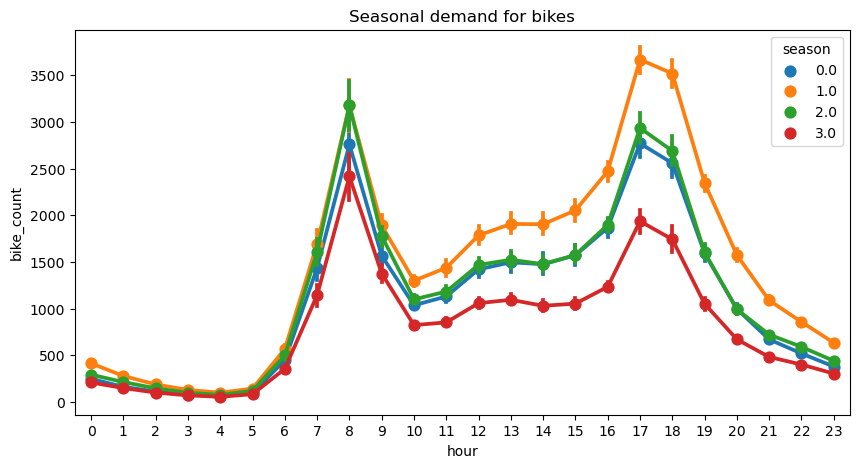

In [13]:
# Visualize bike share demand
fig, ax = plt.subplots(figsize=(10,5))
sns.pointplot(data=bike_df, 
              x='hour', y='bike_count', hue='season',
              ax=ax)
ax.set(title="Seasonal demand for bikes");

As we can see above bike share demand is highest around rush hour 7 to 9 am and 5 to 7pm. Also bike demand is highest around the summer (season = 1). Bike demand is lowest in the winter (season = 3).

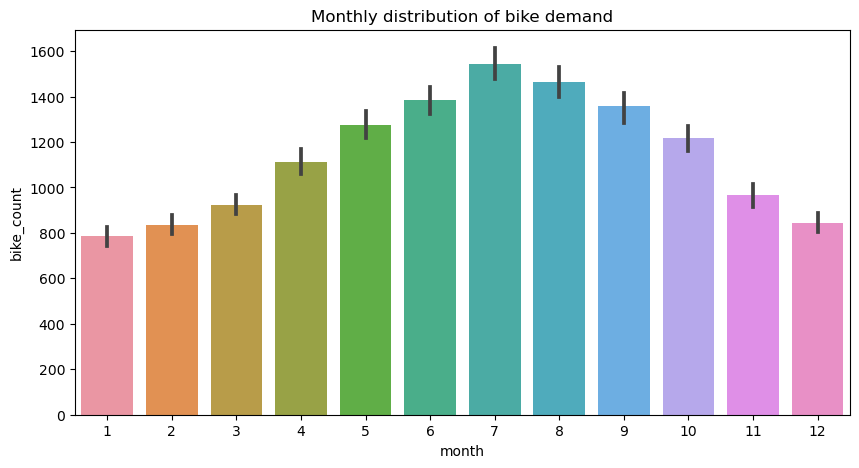

In [14]:
fig,ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=bike_df, x="month",y="bike_count")
ax.set(title="Monthly distribution of bike demand");

Demand is highest around the summer months same as the seasonality chart from above.

<Axes: >

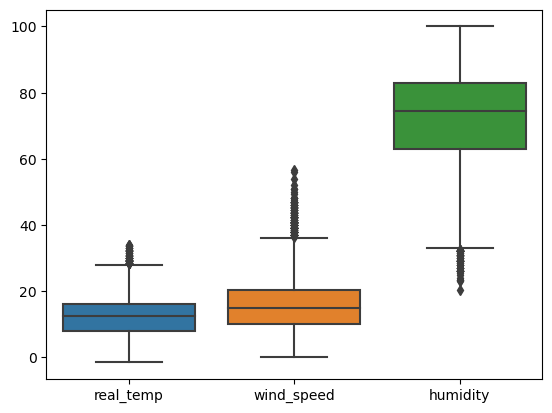

In [15]:
# detect outliers using boxplot
fig,ax = plt.subplots()
sns.boxplot(data=bike_df[['real_temp','wind_speed', 'humidity']])

For each of the above attributes there are a good number of outliers.

In [16]:
bike_df.corr()

/tmp/ipykernel_3198/3116003657.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  bike_df.corr()


,bike_count,real_temp,feels_like_temp,humidity,wind_speed,hour,month
bike_count,1.000000,0.388798,0.369035,-0.462901,0.116295,0.324423,0.063757
real_temp,0.388798,1.000000,0.988344,-0.447781,0.145471,0.168708,0.332712
feels_like_temp,0.369035,0.988344,1.000000,-0.403495,0.088409,0.153956,0.368366
humidity,-0.462901,-0.447781,-0.403495,1.000000,-0.287789,-0.295653,0.113149
wind_speed,0.116295,0.145471,0.088409,-0.287789,1.000000,0.141792,-0.086383
hour,0.324423,0.168708,0.153956,-0.295653,0.141792,1.000000,-0.000312
month,0.063757,0.332712,0.368366,0.113149,-0.086383,-0.000312,1.000000


# Feature Selection and Engineering

In [17]:
numerical_features = ['real_temp', 'feels_like_temp', 'humidity', 'wind_speed']
temporal_features = ['hour', 'month', 'timestamp', 'date']
categorical_features = ['weather_code', 'is_holiday', 'is_weekend', 'season']

In [18]:
print(bike_df[categorical_features].head())

  weather_code is_holiday is_weekend season
0          3.0        0.0        1.0    3.0
1          1.0        0.0        1.0    3.0
2          1.0        0.0        1.0    3.0
3          1.0        0.0        1.0    3.0
4          1.0        0.0        1.0    3.0


In [20]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first')

# Fit and transform the data
encoded_data = encoder.fit_transform(bike_df[categorical_features])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_features))

In [21]:
encoder.get_feature_names_out(categorical_features)

array(['weather_code_2.0', 'weather_code_3.0', 'weather_code_4.0',
       'weather_code_7.0', 'weather_code_10.0', 'weather_code_26.0',
       'is_holiday_1.0', 'is_weekend_1.0', 'season_1.0', 'season_2.0',
       'season_3.0'], dtype=object)

In [22]:
X = pd.concat([bike_df[numerical_features], encoded_df], axis=1)

In [23]:
y = bike_df['bike_count']

# Split Data and Build Model

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [25]:
X_train

,real_temp,feels_like_temp,humidity,wind_speed,weather_code_2.0,weather_code_3.0,weather_code_4.0,weather_code_7.0,weather_code_10.0,weather_code_26.0,is_holiday_1.0,is_weekend_1.0,season_1.0,season_2.0,season_3.0
12059,13.5,13.5,65.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4870,14.0,14.0,88.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
11820,14.5,14.5,74.5,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14753,19.5,19.5,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4045,14.5,14.5,72.5,19.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,8.0,5.0,87.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11964,13.0,13.0,79.5,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,14.0,14.0,82.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
860,5.0,2.0,78.5,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [26]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

# Make Predictions and Evaluate Model



In [27]:
y_pred = model.predict(X_test)

In [28]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 868440.44200793
Mean Absolute Error: 684.4848901531333
R-squared: 0.27523844375409046


# Conclusion

This model does not appear to be a very good predictor for bike share demand. It might need further preprocessing of data or another ML model.